In [51]:
# Standard Data Science Toolkit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt; plt.style.use("ggplot")
%matplotlib inline
import seaborn as sns

# Machine Learning Preprocessing and Scoring Metrics
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score, RepeatedKFold, KFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import SelectFromModel
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import time
import psutil
import os

# Machine Learning Algorithms
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.svm import SVC, SVR
from tpot import TPOTClassifier

# Deep Learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, SimpleRNN, LSTM, GRU
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.random import set_seed
from keras.regularizers import l2, l1

# Setup to Ignore Version Errors and Deprecations
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Set seed for reproducibility
np.random.seed(42)
set_seed(42)

In [3]:
df = pd.read_csv('data.csv', index_col='date', parse_dates=["date"])
df.drop(columns=['adj_close'], inplace=True)     # Colinear features observed from EDA notebook
df.head()

,open,high,low,close,volume,interest_rate,gdp_growth,inflation_rate,unemployment_rate,consumer_sentiment
date,,,,,,,,,,
2000-01-03,96.1875,96.1875,90.7500,94.75000,36345200,5.43,7.5,2.826171,4.1,111.3
2000-01-04,92.0000,93.5000,87.9375,88.25000,33786600,5.38,7.5,2.826171,4.1,111.3
2000-01-05,87.5000,89.6250,84.2500,86.00000,42496600,5.41,7.5,2.826171,4.1,111.3
2000-01-06,86.8750,88.0000,79.7500,80.09375,37134800,5.54,7.5,2.826171,4.1,111.3
2000-01-07,82.9375,90.0000,82.5000,90.00000,28138200,5.61,7.5,2.826171,4.1,111.3


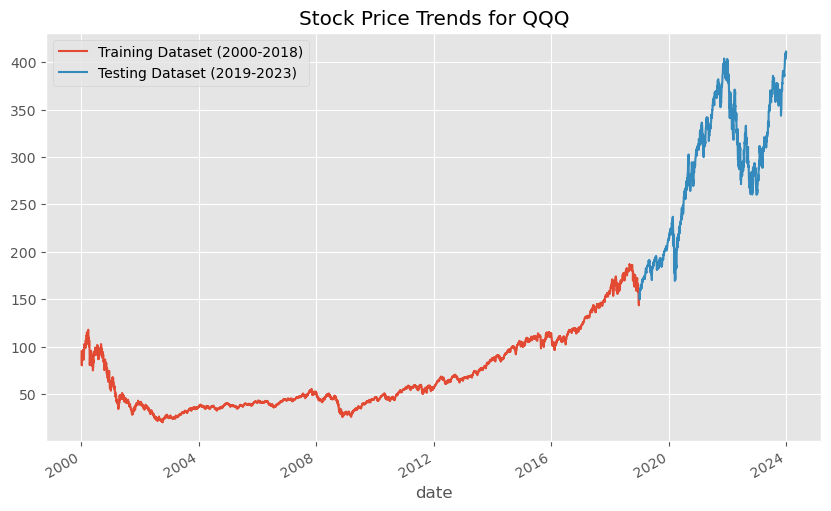

In [4]:
df['close'][:'2018-12-31'].plot(figsize=(10,6), legend=True)
df['close']['2019-01-01':].plot(figsize=(10,6), legend=True)

plt.legend(["Training Dataset (2000-2018)", "Testing Dataset (2019-2023)"])
plt.title("Stock Price Trends for QQQ")
plt.show()

In [5]:
train = df[df.index <= '2018-12-31']
test = df[df.index > '2018-12-31']

In [ ]:
X_train  = train.reset_index()
X_train.drop(columns=['date', 'close'], inplace=True)
display(X_train.head())

X_test  = test.reset_index()
X_test.drop(columns=['date', 'close'], inplace=True)
display(X_test.head())

,open,high,low,volume,interest_rate,gdp_growth,inflation_rate,unemployment_rate,consumer_sentiment
0,96.1875,96.1875,90.7500,36345200,5.43,7.5,2.826171,4.1,111.3
1,92.0000,93.5000,87.9375,33786600,5.38,7.5,2.826171,4.1,111.3
2,87.5000,89.6250,84.2500,42496600,5.41,7.5,2.826171,4.1,111.3
3,86.8750,88.0000,79.7500,37134800,5.54,7.5,2.826171,4.1,111.3
4,82.9375,90.0000,82.5000,28138200,5.61,7.5,2.826171,4.1,111.3


,open,high,low,volume,interest_rate,gdp_growth,inflation_rate,unemployment_rate,consumer_sentiment
0,150.990005,155.750000,150.880005,58576700,2.4,3.4,1.233584,3.8,93.8
1,152.600006,153.259995,149.490005,74820200,2.4,3.4,1.233584,3.8,93.8
2,152.339996,157.000000,151.740005,74709300,2.4,3.4,1.233584,3.8,93.8
3,156.619995,158.860001,156.110001,52059300,2.4,3.4,1.233584,3.8,93.8
4,159.539993,160.110001,157.199997,49388700,2.4,3.4,1.233584,3.8,93.8


In [7]:
y_train = train.reset_index()
y_train = y_train['close']
display(y_train.head())

y_test = test.reset_index()
y_test = y_test['close']
display(y_test.head())

0    94.75000
1    88.25000
2    86.00000
3    80.09375
4    90.00000
Name: close, dtype: float64

0    154.880005
1    149.820007
2    156.229996
3    158.089996
4    159.520004
Name: close, dtype: float64

In [8]:
mm_scaler = MinMaxScaler()

X_train_scaled = mm_scaler.fit_transform(X_train)
X_test_scaled = mm_scaler.transform(X_test)

In [63]:
def test_regression_models(X_train, y_train):
    # Adjustments
    CV = 10
    SCORING = 'neg_mean_squared_error' 
    
    # Define the models to be tested
    models = {
        "Lasso": Lasso(),
        "K-Nearest Neighbors": KNeighborsRegressor(),
        "Decision Tree": DecisionTreeRegressor(random_state=42),
        "Random Forest": RandomForestRegressor(random_state=42),
        "Gradient Boosting": GradientBoostingRegressor(random_state=42),
        "XGBoost": XGBRegressor(random_state=42),
        "Support Vector Regressor": SVR()
    }
    
    # Initialize results dictionary to store metrics for each model
    results = {
        "Model": [],
        "Mean Squared Error": [],
        "Spread (std)": [],
        "Train Time (s)": [],
        "Memory Usage (MB)": []
    }
    
    # Perform model evaluation for each model
    for model_name, model in models.items():
        # Measure training time
        start_train_time = time.time()

        # Perform k-fold cross-validation to evaluate the model on the training data
        cv_scores = cross_val_score(model, X_train, y_train, cv=CV, scoring=SCORING)

        end_train_time = time.time()
        train_time = end_train_time - start_train_time

        # Measure memory usage (in MB)
        memory_usage = psutil.Process(os.getpid()).memory_info().rss / (1024 * 1024)
        
        # Convert MSE scores to positive values
        mse_scores = -cv_scores

        # Store the metrics in the results dictionary
        results["Model"].append(model_name)
        results["Mean Squared Error"].append(round(np.mean(mse_scores), 4))
        results["Spread (std)"].append(round(np.std(mse_scores), 4))
        results["Train Time (s)"].append(round(train_time, 4))
        results["Memory Usage (MB)"].append(round(memory_usage, 0))
        
    # Create a DataFrame to display the results
    results_df = pd.DataFrame(results)
    
    # Print the results
    return results_df


In [64]:
test_regression_models(X_train_scaled, y_train)

KeyboardInterrupt: 

Best performing model was Linear Regression. Let's see if we can boost performance.

___

___

In [52]:
lin_reg = Lasso()

ling_reg_param_grid = {
    'fit_intercept': [True, False],
    'positive': [True, False]
}

In [53]:
grid_search = GridSearchCV(estimator=lin_reg, param_grid=ling_reg_param_grid, cv=5, n_jobs=-1, verbose=True)

In [54]:
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=Lasso(), n_jobs=-1,
             param_grid={'fit_intercept': [True, False],
                         'positive': [True, False]},
             verbose=True)

In [55]:
best_lin_reg = grid_search.best_estimator_
best_lin_reg

Lasso(fit_intercept=False, positive=True)

In [56]:
best_lin_reg_score = grid_search.best_score_
best_lin_reg_score

0.5365193814585941

In [57]:
best_lin_reg_pred = best_lin_reg.predict(X_test_scaled)

best_lin_reg_r2 = r2_score(y_test, best_lin_reg_pred)
best_lin_reg_r2

0.8997324225671672

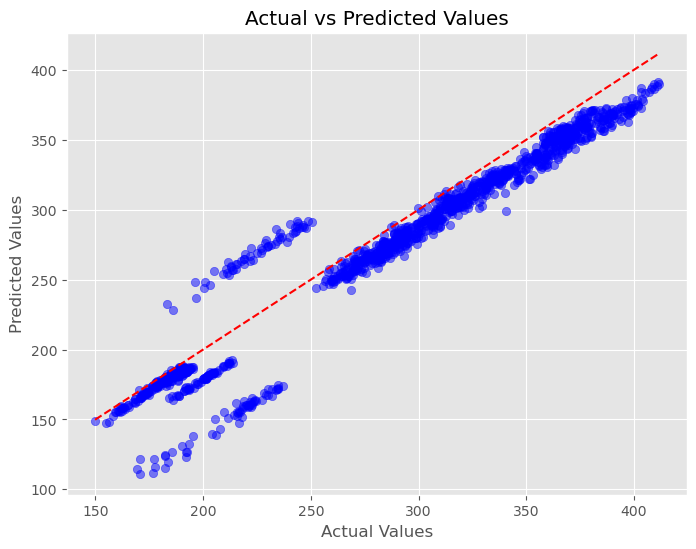

In [58]:
plt.figure(figsize=(8, 6))

# Scatter plot for actual vs predicted values
x = y_test
y = best_lin_reg_pred
plt.scatter(x, y, color='blue', alpha=0.5)

# Add title and labels
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')


# Line showing perfect predictions
plt.plot([x.min(), x.max()], [x.min(), x.max()], color='red', linestyle='--')

plt.show()


### KNN

In [11]:
knn = KNeighborsRegressor()

param_grid = {
    'n_neighbors': [3, 7, 11],
    'weights': ['uniform', 'distance'],
    'leaf_size': [20, 30, 40],
    'p': [1,2],
    'metric': ['minkowski', 'manhattan', 'euclidean']
}

In [12]:
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, n_jobs=-1, verbose=True)

In [13]:
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5, estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'leaf_size': [20, 30, 40],
                         'metric': ['minkowski', 'manhattan', 'euclidean'],
                         'n_neighbors': [3, 7, 11], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             verbose=True)

In [14]:
best_knn = grid_search.best_estimator_
best_knn

KNeighborsRegressor(leaf_size=20, n_neighbors=3, p=1, weights='distance')

In [15]:
best_score = grid_search.best_score_
best_score

-0.17436008530134717

In [16]:
best_knn_pred = best_knn.predict(X_test_scaled)

In [ ]:
best_knn_r2 = r2_score(y_test, best_knn_pred)
best_knn_r2

-2.213468793262131

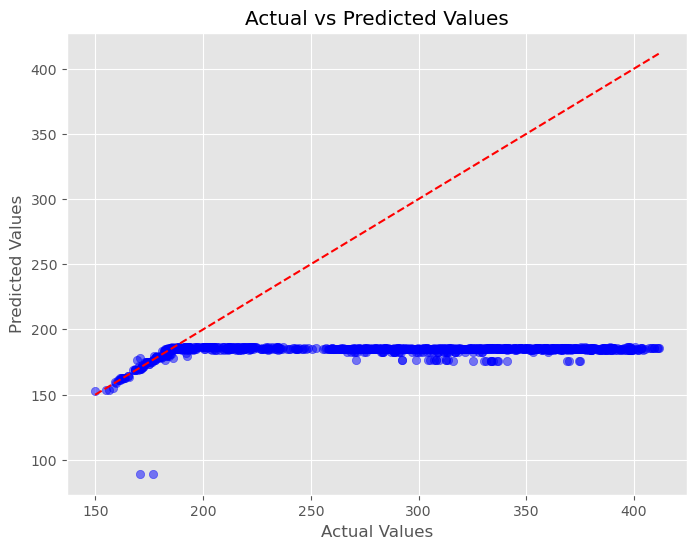

In [18]:
plt.figure(figsize=(8, 6))

# Scatter plot for actual vs predicted values
x = y_test
y = best_knn_pred
plt.scatter(x, y, color='blue', alpha=0.5)

# Add title and labels
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')


# Line showing perfect predictions
plt.plot([x.min(), x.max()], [x.min(), x.max()], color='red', linestyle='--')

plt.show()


Interpretation:

Even best KNN is unable to perform well on predictive task.

___

In [20]:
rnn_data = pd.read_csv('data.csv', index_col='date', parse_dates=["date"])
rnn_data.drop(columns=['high', 'low', 'adj_close'], inplace=True)
rnn_data.head()

,open,close,volume,interest_rate,gdp_growth,inflation_rate,unemployment_rate,consumer_sentiment
date,,,,,,,,
2000-01-03,96.1875,94.75000,36345200,5.43,7.5,2.826171,4.1,111.3
2000-01-04,92.0000,88.25000,33786600,5.38,7.5,2.826171,4.1,111.3
2000-01-05,87.5000,86.00000,42496600,5.41,7.5,2.826171,4.1,111.3
2000-01-06,86.8750,80.09375,37134800,5.54,7.5,2.826171,4.1,111.3
2000-01-07,82.9375,90.00000,28138200,5.61,7.5,2.826171,4.1,111.3


In [21]:
train = rnn_data[rnn_data.index <= '2018-12-31']
test = rnn_data[rnn_data.index > '2018-12-31']

In [22]:
X_train  = train.reset_index()
X_train.drop(columns=['date', 'close'], inplace=True)
display(X_train.head())

X_test  = test.reset_index()
X_test.drop(columns=['date', 'close'], inplace=True)
display(X_test.head())

,open,volume,interest_rate,gdp_growth,inflation_rate,unemployment_rate,consumer_sentiment
0,96.1875,36345200,5.43,7.5,2.826171,4.1,111.3
1,92.0000,33786600,5.38,7.5,2.826171,4.1,111.3
2,87.5000,42496600,5.41,7.5,2.826171,4.1,111.3
3,86.8750,37134800,5.54,7.5,2.826171,4.1,111.3
4,82.9375,28138200,5.61,7.5,2.826171,4.1,111.3


,open,volume,interest_rate,gdp_growth,inflation_rate,unemployment_rate,consumer_sentiment
0,150.990005,58576700,2.4,3.4,1.233584,3.8,93.8
1,152.600006,74820200,2.4,3.4,1.233584,3.8,93.8
2,152.339996,74709300,2.4,3.4,1.233584,3.8,93.8
3,156.619995,52059300,2.4,3.4,1.233584,3.8,93.8
4,159.539993,49388700,2.4,3.4,1.233584,3.8,93.8


In [23]:
y_train = train.reset_index()
y_train = y_train['close']
display(y_train.head())

y_test = test.reset_index()
y_test = y_test['close']
display(y_test.head())

0    94.75000
1    88.25000
2    86.00000
3    80.09375
4    90.00000
Name: close, dtype: float64

0    154.880005
1    149.820007
2    156.229996
3    158.089996
4    159.520004
Name: close, dtype: float64

In [24]:
mm_scaler = MinMaxScaler()

X_train_scaled = mm_scaler.fit_transform(X_train)
X_test_scaled = mm_scaler.transform(X_test)

___

In [25]:
# Function to create window for given timesteps
def create_window(data, target, timesteps):
    X, y = [], []
    for i in range (timesteps, len(data)):
        X.append(data[i-timesteps: i])
        y.append(target[i])
    return np.array(X), np.array(y)

In [26]:
# Fit to scaled data with timesteps=30
X_train_rnn, y_train_rnn = create_window(X_train_scaled, y_train, 30)
X_test_rnn, y_test_rnn = create_window(X_test_scaled, y_test, 30)

In [27]:
# Used to moderate training and validation time
early_stopping = EarlyStopping(
    monitor='val_loss',    
    patience=5,           
    restore_best_weights=True
)

In [37]:
simple_rnn = Sequential()

simple_rnn.add(SimpleRNN(units=50,
                         input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2]),
                         return_sequences=True))
simple_rnn.add(Dense(1))

simple_rnn.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 30, 50)            2900      
                                                                 
 dense_3 (Dense)             (None, 30, 1)             51        
                                                                 
Total params: 2,951
Trainable params: 2,951
Non-trainable params: 0
_________________________________________________________________


In [38]:
simple_rnn.compile(optimizer='adam', loss='mean_squared_error')

simple_rnn_history = simple_rnn.fit(X_train_rnn, y_train_rnn,
                                    epochs=30, batch_size=32,
                                    validation_data=(X_test_rnn, y_test_rnn),
                                    callbacks=[early_stopping])

Epoch 1/30
149/149 [==============================] - 12s 48ms/step - loss: 5089.0615 - val_loss: 81670.1562
Epoch 2/30
149/149 [==============================] - 7s 47ms/step - loss: 4091.6863 - val_loss: 77583.1406
Epoch 3/30
149/149 [==============================] - 6s 38ms/step - loss: 3437.4670 - val_loss: 74015.9219
Epoch 4/30
149/149 [==============================] - 4s 28ms/step - loss: 2928.1804 - val_loss: 70849.8828
Epoch 5/30
149/149 [==============================] - 4s 25ms/step - loss: 2536.6287 - val_loss: 68021.5156
Epoch 6/30
149/149 [==============================] - 4s 26ms/step - loss: 2240.5015 - val_loss: 65563.5625
Epoch 7/30
149/149 [==============================] - 4s 28ms/step - loss: 2022.0087 - val_loss: 63425.2852
Epoch 8/30
149/149 [==============================] - 5s 33ms/step - loss: 1865.8652 - val_loss: 61577.4414
Epoch 9/30
149/149 [==============================] - 4s 24ms/step - loss: 1757.6895 - val_loss: 60043.9609
Epoch 10/30
149/149 [======

In [30]:
# Function to plot Loss by Epoch
def plot_loss(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss by Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    return plt.show()

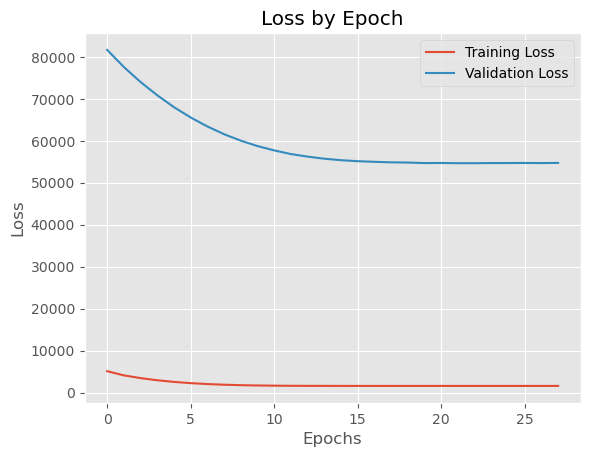

In [39]:
# Simple RNN
plot_loss(simple_rnn_history)

Despite a steady decline in loss for the training function, the model is still failiing to perform on well on test data. Minimum validation loss is around 55k.

Let's try LSTM

In [32]:
lstm = Sequential()

lstm.add(LSTM(units=50,
              input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2]),
              return_sequences=False))
lstm.add(Dense(1))
lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                11600     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 11,651
Trainable params: 11,651
Non-trainable params: 0
_________________________________________________________________


In [33]:
lstm.compile(optimizer='adam', loss='mean_squared_error')
lstm_history = lstm.fit(X_train_rnn, y_train_rnn,
                                    epochs=30, batch_size=32,
                                    validation_data=(X_test_rnn, y_test_rnn),
                                    callbacks=[early_stopping])

Epoch 1/30
149/149 [==============================] - 12s 43ms/step - loss: 5011.4595 - val_loss: 80820.1406
Epoch 2/30
149/149 [==============================] - 6s 39ms/step - loss: 3929.5747 - val_loss: 76756.2734
Epoch 3/30
149/149 [==============================] - 6s 39ms/step - loss: 3300.4771 - val_loss: 73279.9766
Epoch 4/30
149/149 [==============================] - 6s 37ms/step - loss: 2820.6460 - val_loss: 70223.0781
Epoch 5/30
149/149 [==============================] - 5s 35ms/step - loss: 2456.2598 - val_loss: 67504.1406
Epoch 6/30
149/149 [==============================] - 7s 44ms/step - loss: 2182.7556 - val_loss: 65147.3438
Epoch 7/30
149/149 [==============================] - 9s 57ms/step - loss: 1981.8943 - val_loss: 63098.5391
Epoch 8/30
149/149 [==============================] - 6s 37ms/step - loss: 1838.7880 - val_loss: 61327.7461
Epoch 9/30
149/149 [==============================] - 8s 51ms/step - loss: 1739.8818 - val_loss: 59859.4023
Epoch 10/30
149/149 [======

KeyboardInterrupt: 

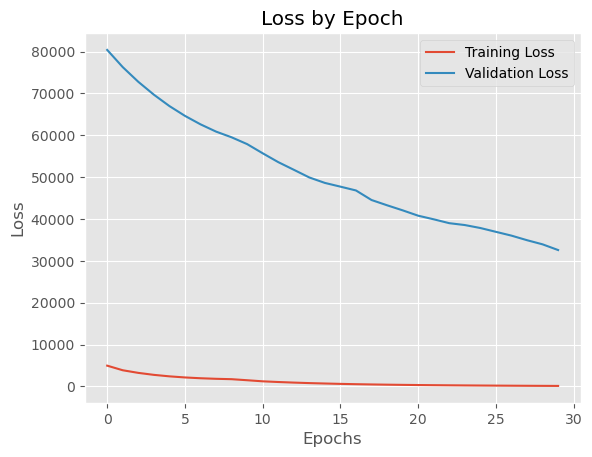

In [ ]:
# LSTM
plot_loss(lstm_history)

Minimum validation loss near 55k. Let's take a look at GRU

In [ ]:
gru = Sequential()

gru.add(GRU(units=50,
            input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2]),
            return_sequences=False))
gru.add(Dense(1))
gru.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 50)                9150      
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 9,201
Trainable params: 9,201
Non-trainable params: 0
_________________________________________________________________


In [ ]:
gru.compile(optimizer='adam', loss='mean_squared_error')
gru_history = gru.fit(X_train_rnn, y_train_rnn,
                      epochs=30, batch_size=32,
                      validation_data=(X_test_rnn, y_test_rnn),
                      callbacks=[early_stopping])

Epoch 1/30
149/149 [==============================] - 8s 31ms/step - loss: 4914.6445 - val_loss: 80289.5234
Epoch 2/30
149/149 [==============================] - 4s 26ms/step - loss: 3831.7856 - val_loss: 76181.6875
Epoch 3/30
149/149 [==============================] - 4s 25ms/step - loss: 3210.2395 - val_loss: 72687.1562
Epoch 4/30
149/149 [==============================] - 4s 27ms/step - loss: 2740.7061 - val_loss: 69625.5312
Epoch 5/30
149/149 [==============================] - 4s 26ms/step - loss: 2387.9668 - val_loss: 66914.1250
Epoch 6/30
149/149 [==============================] - 4s 27ms/step - loss: 2126.5750 - val_loss: 64578.6914
Epoch 7/30
149/149 [==============================] - 4s 28ms/step - loss: 1937.4799 - val_loss: 62562.7539
Epoch 8/30
149/149 [==============================] - 4s 30ms/step - loss: 1805.1481 - val_loss: 60834.2227
Epoch 9/30
149/149 [==============================] - 4s 30ms/step - loss: 1715.5443 - val_loss: 59417.3672
Epoch 10/30
149/149 [=======

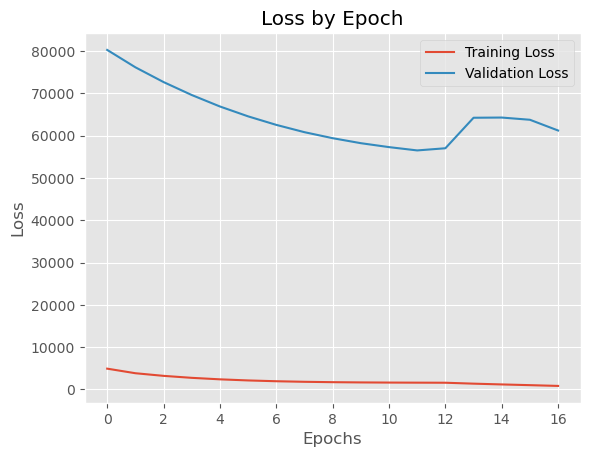

In [ ]:
plot_loss(gru_history)

Minimum validation loss near 58k

The simple RNN and LSTM had the best baseline performance. Because LSTM is better with more complex data I'll continue building that out to further reduce validation loss.

In [59]:
best_rnn = Sequential()

# Layer 1
best_rnn.add(LSTM(units=32,
                  input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2]),
                  return_sequences=True,
                  kernel_regularizer=l1(0.01)))
best_rnn.add(Dropout(0.40))

# Layer 2
best_rnn.add(LSTM(units=32,
                  return_sequences=False,
                  kernel_regularizer=l1(0.01)))
best_rnn.add(Dropout(0.40))

# Dense Layer
best_rnn.add(Dense(units=16))

# Output Layer
best_rnn.add(Dense(1))
best_rnn.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 30, 32)            5120      
                                                                 
 dropout (Dropout)           (None, 30, 32)            0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 13,985
Trainable params: 13,985
Non-trai

In [60]:
optimizer = SGD(learning_rate=0.001, momentum=0.9)

best_rnn.compile(optimizer=optimizer, loss='mean_squared_error')
best_rnn_history = best_rnn.fit(X_train_rnn, y_train_rnn,
                      epochs=30, batch_size=32,
                      validation_data=(X_test_rnn, y_test_rnn),
                      callbacks=[early_stopping])

Epoch 1/30
149/149 [==============================] - 11s 40ms/step - loss: 1681.5957 - val_loss: 53334.0000
Epoch 2/30
149/149 [==============================] - 4s 29ms/step - loss: 1644.2944 - val_loss: 53812.3203
Epoch 3/30
149/149 [==============================] - 5s 31ms/step - loss: 1679.5260 - val_loss: 58949.7734
Epoch 4/30
149/149 [==============================] - 5s 32ms/step - loss: 1694.8433 - val_loss: 52774.9492
Epoch 5/30
149/149 [==============================] - 4s 30ms/step - loss: 1657.1946 - val_loss: 57773.1328
Epoch 6/30
149/149 [==============================] - 4s 29ms/step - loss: 1635.8510 - val_loss: 56810.3633
Epoch 7/30
149/149 [==============================] - 4s 29ms/step - loss: 1635.9968 - val_loss: 52097.0781
Epoch 8/30
149/149 [==============================] - 5s 32ms/step - loss: 1631.6222 - val_loss: 56711.3672
Epoch 9/30
149/149 [==============================] - 5s 36ms/step - loss: 1630.4374 - val_loss: 48868.6641
Epoch 10/30
149/149 [======

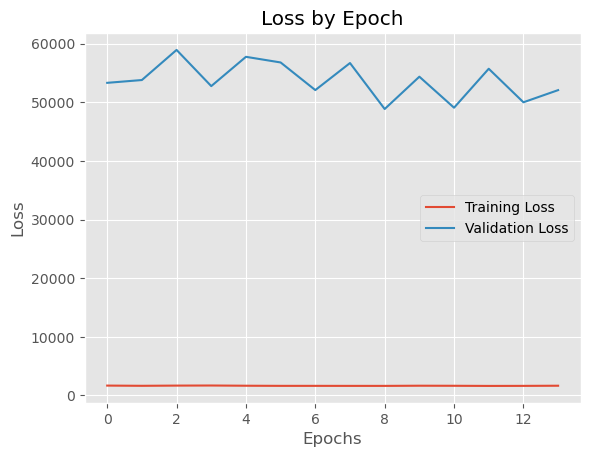

In [61]:
plot_loss(best_rnn_history)

In [62]:
# Get predictions for each model
simple_rnn_pred = simple_rnn.predict(X_test_rnn)
lstm_pred = lstm.predict(X_test_rnn)
gru_pred = gru.predict(X_test_rnn)
best_rnn_pred = best_rnn.predict(X_test_rnn)

# Plot actual vs predicted values
plt.figure(figsize=(12,6))
plt.plot(y_test_rnn, label='Actual Values', color='blue')

plt.plot(simple_rnn_pred, label='Simple RNN', color='red', linestyle='--')
plt.plot(lstm_pred, label='LSTM', color='green', linestyle='-.')
plt.plot(gru_pred, label='GRU', color='orange', linestyle=':')
plt.plot(best_rnn_pred, label='Best RNN', color='purple', linestyle='dotted')


plt.title('Actual vs Predicted Values')
plt.xlabel('Days Since 1/1/2019')
plt.ylabel('Value')
plt.legend()
plt.show()


39/39 [==============================] - 1s 6ms/step


NameError: name 'gru' is not defined